**Module 2 :** 6.0_chatbot_external_memory,
 6.1_chatbot_external_memory_with_our_db_file.ipynb, 6.2_chatbot_external_memory_with_postgres.ipynb

[Class08:LangGraph: External Memory with External DB, Introduction to Agentic RAG - Nov 23, 2024](https://www.youtube.com/watch?v=ooU238RcOdo)


**rm notes**



In the old functionality, the script only shows the default messages and does not append new messages after disconnecting from the environment. To save our new data into a script file and persist it, we need to update the script. We can then save the updated file to the drive or download it to our system, and use the new appended file as required.

To append our newly updated data into a file and either save it to the drive or our system, we have three use cases:

Save a newly updated file with its name and designation either to the system or drive, and then proceed with further functionality from it.

**use case**
1. Fetching a Database File from a GitHub URL
2. Uploading a Database File from Your Local System
3. Accessing a Database File from Google Drive




**Delete all but the 2 most recent messages**

```
 delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
```

**Define a graph**

```
from langgraph.graph import StateGraph
from langgraph.graph.state import CompiledStateGraph

workflow: StateGraph = StateGraph(State)
graph: CompiledStateGraph = workflow.compile()

```

**Create a thread**
```
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

config = {"configurable": {"thread_id": "2"}}
```

**Start conversation**

```
input_message = HumanMessage(content="I am Raheela, my designation is Director")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()
```

**Retrieve state using thread ID** **(Snapshot)**



```
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state
```


**len(messages) :- number of messages**

```
config = {"configurable": {"thread_id": "1"}}
messages = graph.get_state(config).values.get("messages")
len(messages)
```

**Get Summary**

```
graph_state = graph.get_state(config).values.get("summary","")
graph_state
```

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer.

We've also shown a number of tricks for trimming or filtering messages in graph state.

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases.

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

## Use Cases for Database File Management:
1. Fetching a Database File from a GitHub URL
2. Uploading a Database File from Your Local System
3. Accessing a Database File from Google Drive

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_google_genai

In [ ]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
import os
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database.

If we supply `":memory:"` it creates an in-memory Sqlite database.

In [ ]:
import sqlite3
# In memory - temporary database is created, not on-disk database
conn = sqlite3.connect(":memory:", check_same_thread = False) #check_same_thread = False | allowing multiple threads to share and use the same SQLite database connection. By default it is True

## Default Behavior:

When you run the code for the first time, it will automatically fetch a new example.db file for you.
But, if we supply a db path, then it will create a database for us!:

In [ ]:
import sqlite3
# pull file if it doesn't exist and connect to local db

!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2024-12-06 02:52:32--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2024-12-06 02:52:32--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.01s   

2024-12-06 02:52:33 (8.03 MB/s) - ‘s

## Mount with Google Drive

**3. Accessing a Database File from Google Drive**


In [ ]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


connection is establish

**rm note**

The first time you create the file and then  to save it to the drive, it gives an error because the file is not yet created.

In [ ]:
import sqlite3
file_path = '/content/drive/My Drive/state_db/example.db'
conn = sqlite3.connect(file_path)

OperationalError: unable to open database file

### When you want to pass your DB file:
You need example.db as well as example.db-wal file to retrieve your previous data.

Sqlite uses these 3 files:


1.   example.db
2.   example.db-wal
3.   example.db-shm

### How SQLite Uses These Files
1. example.db:
  This is the main database file where committed data is stored.

2. example.db-wal:
  If SQLite is in WAL mode, this file temporarily holds changes that
  have not been checkpointed (written to example.db).
  SQLite automatically reads from this file when you connect to the database.

3. example.db-shm:
  This file is used for shared memory when multiple connections are accessing the same database.
  It is a temporary file and does not affect persistence.



### Why you need to save example.db-wal file along with example.db file?

1. **Uncommitted Changes Are Stored in `example.db-wal`**:
   - In WAL mode, SQLite writes all changes to the `example.db-wal` file instead of directly modifying the main `example.db` file.
   - These changes are only merged (checkpointed) into `example.db` when a checkpoint operation occurs.

   If you only copy or use the `example.db` file without the `example.db-wal`, **any uncommitted changes in the WAL file will be lost.**

2. **Ensures Data Consistency**:
   - If you transfer the database (`example.db`) to another system without the `example.db-wal`, the database may appear incomplete or inconsistent if there are pending writes stored in the WAL file.

3. **Concurrent Access**:
   - The WAL file allows multiple processes to read from the database while another process writes to it, without blocking each other. If this feature is in use, the `example.db-wal` file is essential for proper functionality.



In [ ]:
#Follow step if you already have previous database file
#uplaod example.db file from your system
from google.colab import files
uploaded = files.upload()


Saving example.db to example.db


In [ ]:
#Follow step if you already have previous database file
#upload example.db-wal file from your system
uploaded = files.upload()


Saving example.db-wal to example.db-wal


In [ ]:
#Follow step if you already have previous database file
#move both files to state_db folder and establish a connection:

import sqlite3
import shutil
import os

# Ensure the state_db directory exists
os.makedirs("state_db", exist_ok=True)

# Move the uploaded files to the state_db directory
shutil.move("example.db", "state_db/example.db")
if os.path.exists("example.db-wal"):  # Check if WAL file exists
    shutil.move("example.db-wal", "state_db/example.db-wal")
    print("WAL file moved successfully.")
else:
    print("No WAL file found. Proceeding with example.db only.")

# Define the path to the main database file
db_path = "state_db/example.db"

# Connect to the SQLite database
try:
    conn = sqlite3.connect(db_path, check_same_thread=False)
    print(f"Connected to database: {db_path}")
except sqlite3.OperationalError as e:
    print(f"Error connecting to the database: {e}")


WAL file moved successfully.
Connected to database: state_db/example.db


In [ ]:
#conect to the above created connection (rm note)
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory: SqliteSaver = SqliteSaver(conn)

Let's re-define our chatbot.

**rm note ** with some extra messages

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash", api_key =  GEMINI_API_KEY)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State) -> State:

    # Get summary if it exists
    summary = state.get("summary", "")
    print(f"Using summary: {summary}")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State) -> State:
    print(f"Messages before summarizing: {len(state['messages'])}")
    # First, we get any existing summary
    summary = state.get("summary", "")
    print(f"Existing summary: {summary}")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"


    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # Summarization logic
    print(f"New summary: {response.content}")

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    print(f"Messages after truncation: {len(delete_messages)}")
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> State:

    """Return the next node to execute."""

    messages = state["messages"]
    print(f"Message count: {len(messages)}")
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

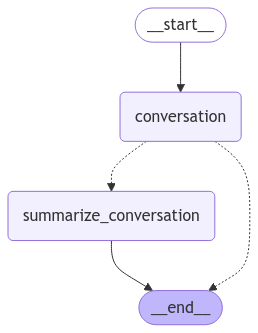

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="I would like to know about circket.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()


Using summary: Here's an extended summary of the conversation:

Lance introduced himself twice, expressing his fondness for the San Francisco 49ers. The AI assistant acknowledged his name and offered to discuss various aspects of the team.  However, instead of engaging with the offered topics about the 49ers, Lance abruptly shifted the conversation to cricket, expressing an interest in learning about the sport.  The conversation then transitioned to a description of cricket, including its various formats (Test Matches, ODIs, and T20), highlighting the differences in length and pace of play. The AI assistant offered to delve deeper into specific aspects of cricket based on Lance's preferences, demonstrating adaptability in responding to the change of topic.  The conversation, while initially focused on American football, ultimately showcased a shift to a different sport and a willingness from both participants to explore new topics.

Message count: 6
================================== A

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="I am Raheela, my designation is Director")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()


Using summary: 
Message count: 2
================================== Ai Message ==================================

Okay, Raheela, Director.  Is there anything I can help you with?


Let's confirm that our state is saved locally.

In [ ]:
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()


Using summary: The conversation began with Lance introducing himself twice, expressing his enthusiasm for the San Francisco 49ers.  The AI assistant acknowledged his name and offered to discuss the team. However, Lance quickly changed the subject to cricket, demonstrating a spontaneous shift in interest.  The AI then provided a comprehensive overview of cricket, explaining its rules, scoring system, and different formats (Test Matches, ODIs, and T20).  The AI’s responses were consistently adaptable, shifting from American football to cricket and providing detailed information upon request.  Following the explanation of cricket, the conversation took an unexpected turn when Lance, seemingly forgetting the prior conversation, again inquired about the sport. This repetition highlights a potential disconnect or lapse in memory on Lance's part.  Finally, the conversation concluded with Lance asking the AI for his name, to which the AI responded that it had no access to personal information 

In [ ]:
input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: 
Message count: 6
================================== Ai Message ==================================

That's great!  Go Niners!


In [ ]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='I would like to know about circket.', additional_kwargs={}, response_metadata={}, id='f4f39c23-29b7-4bed-bb61-fa4bad4b91a7'), AIMessage(content="Cricket is a bat-and-ball game played between two teams of eleven players on a field at the centre of which is a 22-yard pitch with a wicket at each end.  The game is played with a hard ball, and the aim is to score more runs than the opposing team.  There are several formats of cricket:\n\n* **Test Matches:**  These are the longest format, lasting five days.  They're known for their tactical depth and often result in drawn matches.\n\n* **One Day Internationals (ODIs):**  Each team has 50 overs (an over is a set of six legal deliveries bowled by a single bowler).  This is a faster-paced format than Test matches.\n\n* **Twenty20 (T20):** This is the shortest and fastest-growing format, with each team having only 20 overs.  It's known for its explosive hitting and shorter matches.\n\nWhat

In [ ]:
config = {"configurable": {"thread_id": "1"}}
messages = graph.get_state(config).values.get("messages")
len(messages)

4

In [ ]:
graph_state = graph.get_state(config).values.get("summary","")
graph_state

"The conversation began with Lance introducing himself twice, expressing his enthusiasm for the San Francisco 49ers.  The AI assistant acknowledged his name and offered to discuss the team. However, Lance quickly changed the subject to cricket, demonstrating a spontaneous shift in interest.  The AI then provided a comprehensive overview of cricket, explaining its rules, scoring system, and different formats (Test Matches, ODIs, and T20).  The AI’s responses were consistently adaptable, shifting from American football to cricket and providing detailed information upon request.  Following the explanation of cricket, the conversation took an unexpected turn when Lance, seemingly forgetting the prior conversation, again inquired about the sport. This repetition highlights a potential disconnect or lapse in memory on Lance's part.  Finally, the conversation concluded with Lance asking the AI for his name, to which the AI responded that it had no access to personal information not explicitly

**download file**

In [ ]:
# see the how many file we have, important one is example.db, example.db
!ls state_db


example.db  example.db-shm  example.db-wal


**rm notes**

why we require  example.db-shm

Download required db files

In [ ]:
from google.colab import files
files.download('state_db/example.db')
files.download('state_db/example.db-wal')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Persisting state

Using database like Sqlite means state is persisted!

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Now that we better understand external memory, recall that the LangGraph API packages your code and provides you with with built-in persistence.

And the API is the back-end for Studio!

Load the `chatbot` in the UI, which uses `module2-/studio/chatbot.py` set in `module2-/studio/langgraph.json`.